# Clustering Algorithms -  Centroid-based or Partition Clustering

**Partitional clustering** divides data objects into nonoverlapping groups. In other words, no object can be a member of more than one cluster, and every cluster must have at least one object.

These techniques require the user to specify the number of clusters, indicated by the variable k. Many partitional clustering algorithms work through an iterative process to assign subsets of data points into k clusters.

Most partitional clustering algorithms are **nondeterministic**, meaning they could produce different results from two separate runs even if the runs were based on the same input.

Partitional clustering methods have several **strengths**:

- They work well when clusters have a spherical shape.
- They’re scalable with respect to algorithm complexity.

They also have several **weaknesses**:

- They’re not well suited for clusters with complex shapes and different sizes.
- They break down when used with clusters of different densities.

Pre-defining the number of clusters at the initial stage is the most crucial yet most complicated stage for the clustering approach. Despite its drawbacks, partitional clustering algorithms are vastly used for surfacing and optimizing large datasets. 

## Farthest-first traversal

#### Rationale

The Farthest-First Traversal (FFT) algorithm is a clustering algorithm that is used to group data points into clusters based on their distance from one another. The basic idea behind FFT is to select a starting point and then repeatedly choose the farthest point from the current cluster until a specified number of clusters have been created.

The distance between two points is typically measured using the Euclidean distance metric, which calculates the distance between two points in n-dimensional space as the square root of the sum of the squares of the differences between their corresponding coordinates.

**Euclidian Distance**: we define the Euclidean distance between points v = (v1, ... , vm) and w = (w1, ... , wm) in m-dimensional space, denoted d(v, w):

$$
  d(v, w) = \sqrt{\sum_{i=1}^m  (v_i - w_i)^2}
$$


#### Implementation

Here's how the algorithm works:

1. Select a random data point as the starting point for the first cluster.
2. Find the point that is farthest from the first cluster and assign it to the second cluster.
3. Repeat step 2, but now find the point that is farthest from the first two clusters and assign it to the third cluster.
4. Continue this process until the desired number of clusters have been created.

Let's write it in Python:

In [117]:
import numpy as np
import pandas as pd

def euclidean_distance(pointA, pointB):
    distance = 0
    for i in range(len(pointA)):
        distance += (pointA[i] - pointB[i]) ** 2
    distance = distance ** 0.5
    return distance


def distance_from_centroids(centroids, point):
    min_dist = float("Inf")
    for x in centroids:
        current = euclidean_distance(x, point)
        if current < min_dist:
            min_dist = current
    return min_dist


def max_distance_point(data, centroids):
    max_dist = -1
    for point in data:
        current = distance_from_centroids(centroids, point)
        if current > max_dist:
            max_dist = current
            max_point = point
    return max_point


def farthest_first_traversal(data, k):
    # Choose the first point as the starting point
    centroids = [data[0]]

    while len(centroids) < k:
        point = max_distance_point(data, centroids)
        centroids.append(point)
    return centroids

Now we can test the algorithm on a sample dataset. 

In [118]:
# load data from txt file
with open('data/rosalind_ba8a.txt', 'r') as file:
    data = [list(map(float, line.strip().split())) for line in file]

In [119]:
centroid_points = farthest_first_traversal(data, 5)

print("Centroids:")
for centroid in centroid_points:
        print(" ".join(map(str, centroid)))

Centroids:
8.1 20.6 13.4 4.7
4.5 0.5 19.3 33.7
35.5 3.6 14.8 11.0
0.3 0.2 2.4 13.1
7.8 2.4 30.4 7.1


Just above are our centroids dataframe. Let's assign each datapoint to a centroid so that we can visualize the clusters to which data points have been assigned. 

In [120]:
# Define a list to store the assignments
assignments = []

# Iterate over each point in the data
for point in data:
    # Initialize variables to store the minimum distance and index of the closest centroid
    min_distance = float('inf')
    closest_centroid_index = None
    
    # Iterate over each centroid to find the closest one to the current point
    for i, centroid in enumerate(centroid_points):
        # Calculate the Euclidean distance between the current point and the current centroid
        dist = euclidean_distance(point, centroid)
        
        # If the current distance is smaller than the current minimum, update the minimum distance
        # and index of the closest centroid
        if dist < min_distance:
            min_distance = dist
            closest_centroid_index = i
    
    # Add the index of the closest centroid to the assignments list
    assignments.append(closest_centroid_index)

In [121]:

# create pandas df with points and respective assignments
assigned_points = []
for i, point in enumerate(data):
    centroid_idx = assignments[i]
    assigned_points.append(point + [centroid_idx])

assigned_centroids = pd.DataFrame(assigned_points, columns=['x', 'y', 'z', 'w', 'centroid'])

print("Assigned Centroids:")
print(assigned_centroids.head())

Assigned Centroids:
      x     y     z     w  centroid
0   8.1  20.6  13.4   4.7         0
1  12.6  16.9  17.1   1.9         0
2   1.7   8.5   5.0  20.8         3
3   7.1  31.3  16.8   3.8         0
4  10.0   1.9   5.2  15.9         3


Our input data has 4 features, it may be difficult to visualize the cluster assignments using a scatter plot. In this case, we can use a parallel coordinates plot, which plots each data point as a line spanning across all the features.

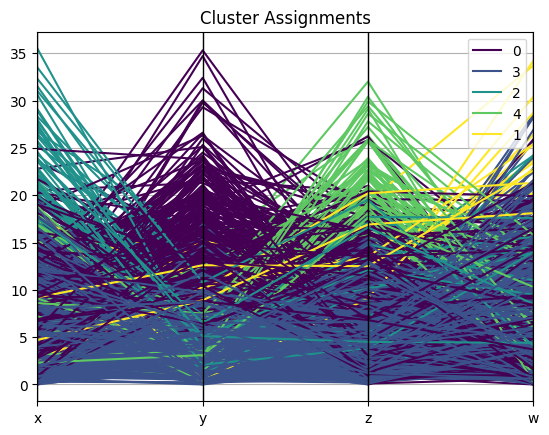

In [122]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Create a parallel coordinates plot
parallel_coordinates(assigned_centroids, 'centroid', colormap='viridis')
plt.title('Cluster Assignments')
plt.show()




#### Closing comments

The FFT algorithm is simple to implement and can be quite effective for data sets with well-separated clusters. However, the algorithm has some strong limitations that should be taken into account when considering its use:

1. Sensitivity to initialization: The FFT algorithm is sensitive to the initial choice of the starting point, which can significantly affect the quality of the resulting clustering. If the starting point is far from the true center of the cluster, the algorithm may converge to a suboptimal solution.
2. Lack of flexibility: The FarthestFirstTraversal algorithm is limited to partitioning the data into a fixed number of clusters, specified in advance. This can be a disadvantage when the number of clusters is not known a priori or when the data does not naturally fall into a fixed number of clusters.
3. **Inability to handle noise and outliers**: The FarthestFirstTraversal algorithm does not have a mechanism for handling noise and outliers, which can affect the quality of the resulting clustering. Outliers can be mistakenly assigned to the nearest cluster center, leading to incorrect clustering results.
4. Computationally expensive: The FarthestFirstTraversal algorithm can be computationally expensive, especially for large datasets, since it requires computing pairwise distances between all data points and all cluster centers at each iteration.


## Squared Error Distortion

To address the limitations of methods that select centroids so that they minimize the maximum distance between points in the data and their nearest centroid, let us introduce a new scoring function. **Squared error distortion** can be used to evaluate the performance of a clustering algorithm by calculating the sum of the squared distances between each data point and its assigned cluster centroid. 

Formally, let C be the set of clusters, and let ci be the centroid of cluster i. The squared error distortion can be calculated as follows:

SE = ∑(x - ci)^2

where x is a data point and ci is the centroid of its assigned cluster.

Let's compute the squared error distortion resulting from clustering done with our FTT algorithm. 

In [123]:
def squared_error_distortion(data, centroid_points):
    distortion = 0
    for point in data:
        distortion += distance_from_centroids(centroid_points, point) ** 2
    distortion /= len(data)
    return distortion

In [124]:
# Compute the distortion
distortion = squared_error_distortion(data, centroid_points)

# Print the distortion
print("Squared Error Distortion:", round(distortion,2))

Squared Error Distortion: 176.99


## Lloyd Algorithm for k-Means Clustering

The Lloyd Algorithm, also known as the k-Means Algorithm, is an iterative clustering algorithm used to partition a set of data points into k clusters. The algorithm aims to minimize the sum of squared distances between each data point and its nearest cluster center.

### Implementation

Here are the steps for the Lloyd Algorithm:

1. Initialize k cluster centers randomly from the data points or using a specific initialization method.
2. Assign each data point to the nearest cluster center based on the Euclidean distance.
3. Recalculate the cluster centers by taking the mean of all data points assigned to each cluster.
4. Repeat steps 2 and 3 until convergence is reached. Convergence is typically determined by a predetermined number of iterations or when the change in cluster centers becomes small.
5. The final result is k clusters, where each data point belongs to the cluster with the nearest cluster center.

Let's write it in Python:


In [125]:
from collections import defaultdict

def closest_center(point, centroids):
    min_dist = float("Inf")
    for x in centroids:
        current = euclidean_distance(x, point)
        if current < min_dist:
            min_dist = current
            closest = x
    return closest


def cluster_mean(cluster):
    m = len(cluster[0])
    centroid = [0] * m
    for point in cluster:
        for i in range(m):
            centroid[i] += point[i]
    centroid = [x / len(cluster) for x in centroid]
    return centroid


def lloyd_k_means(data, k):
    #choose first k points as starting centroids
    centroids = data[:k]

    while True:
        # centroids to clusters
        cluster_assignments = defaultdict(list)
        for point in data:
            centroid = closest_center(point, centroids)
            cluster_assignments[tuple(centroid)].append(point)

        # Clusters to centroids
        new_centroids = [[]] * k
        for i in range(k):
            new_centroids[i] = cluster_mean(cluster_assignments[tuple(centroids[i])])

        if new_centroids == centroids:
            break
        
        centroids = new_centroids[:]

    return centroids

Let's run it on the same dataset as before, and with the same k. 

In [126]:
centroid_points_K_means = lloyd_k_means(data, 5)

for centroid in centroid_points_K_means:
    print(" ".join(map(str, centroid)))

6.63421052631579 17.733157894736834 6.91052631578948 5.7084210526315795
6.435672514619882 6.319298245614032 17.246198830409355 5.911111111111109
19.15448717948718 6.311538461538459 7.619230769230769 8.082692307692305
7.323295454545458 8.028409090909088 7.063068181818187 17.14829545454545
5.148511904761906 4.8023809523809575 4.731547619047619 5.350000000000003


Now let's compute the squared error distortion to compare this algorithm to the FFT:


In [127]:
# Compute the distortion
distortion2 = squared_error_distortion(data, centroid_points_K_means)

# Print the distortion
print("Squared Error Distortion:", round(distortion2,2))

Squared Error Distortion: 70.71


The average squared error distortion is 70.71 using the Lloyd algorithm. This is much lower than the 176.99 average squared error distortion that resulted from the furthest-first traversal algorithm. 

## Closing comments:

The Lloyd Algorithm, also known as the k-means clustering algorithm, has several limitations, including:

- Sensitive to initialization: The algorithm is sensitive to the initial placement of cluster centers, and different initializations may result in different local optima.
- Sensitive to outliers: The algorithm is sensitive to outliers, which may affect the placement of cluster centers and the resulting clusters.
- Requires a fixed number of clusters: The algorithm requires the number of clusters to be specified in advance, which may not always be known or appropriate for the data.
- Not suitable for high-dimensional data: As the number of dimensions increases, the distance metric used in the algorithm becomes less informative, and the algorithm may suffer from the "curse of dimensionality.
- May not work well for non-spherical clusters: The algorithm assumes that clusters are spherical and have similar sizes, which may not hold for all datasets. In some cases, the algorithm may fail to identify the underlying cluster structure, resulting in suboptimal solutions.
- Computationally expensive: The algorithm may be computationally expensive for large datasets or a large number of clusters, as it requires calculating distances and updating cluster centers for each iteration.


#### Comparison with FFT algorithm

The Lloyd Algorithm and the Furthest-First Traversal (FFT) Algorithm are two popular methods used for initializing cluster centers in k-means clustering. The FFT Algorithm selects k initial cluster centers that are as far apart from each other as possible.

Both algorithms have their own advantages and disadvantages, and the choice of initialization method depends on the specific problem and data. Here are some factors to consider when choosing between the two methods:

1. Speed: The FFT Algorithm is generally faster than the Lloyd Algorithm, as it only requires one pass over the data to select initial cluster centers. In contrast, the Lloyd Algorithm requires multiple iterations to converge to a solution.

2. Quality of clusters: The Lloyd Algorithm tends to produce higher quality clusters than the FFT Algorithm, as it iteratively refines the cluster centers and assignments to minimize the sum of squared distances. In contrast, the FFT Algorithm may produce suboptimal clusters if the selected initial cluster centers are not representative of the underlying data.

3. Sensitivity to outliers: The Lloyd Algorithm is more sensitive to outliers than the FFT Algorithm, as outliers may significantly affect the calculation of cluster centers and the resulting clusters. The FFT Algorithm is less sensitive to outliers, as it selects initial cluster centers that are far away from each other and therefore less likely to include outliers.

## Soft k-Means Clustering Algorithm

The **Soft k-Means Clustering Algorithm** is a variation of the traditional k-Means Clustering Algorithm that allows data points to belong to multiple clusters with varying degrees of membership or weights.

In traditional k-means clustering, each data point is assigned to a single cluster, based on its proximity to the cluster's centroid. However, in soft k-means clustering, a data point can belong to **multiple clusters simultaneously**, with a membership weight or degree that represents the degree of similarity between the point and each cluster's centroid.

The algorithm works by iteratively updating the cluster centroids and membership weights until convergence is reached. At each iteration, each data point's membership weights are adjusted based on its distance to the centroids of each cluster, and the centroids are recalculated based on the weighted average of the data points assigned to each cluster.

The soft k-means clustering algorithm is useful in scenarios where a data point may belong to multiple clusters, or where the boundaries between clusters are not well-defined. It has applications in a wide range of fields, including image processing, natural language processing, and bioinformatics.

### Implementation

The soft k-means clustering algorithm starts from randomly chosen centroids and iterates the following two steps:

- **Centroids to Soft Clusters** (E-step): After centroids have been selected, assign each data point a **“responsibility”** value for each cluster, where higher values correspond to stronger cluster membership.

    If we think about the centroids  as stars and the data points as planets, then the closer a point is to a centroid, the stronger that centroid's “pull” should be on the point. Given k centroids Centers = (x1, ..., xk), and n points Data = (Data1, ... , Datan), we therefore need to construct a k × n responsibility matrix *HiddenMatrix* for which HiddenMatrix<sub>i,j</sub> is the pull of center i on data point j. This pull can be computed according to the Newtonian inverse-square law of gravitation. 

    $$
        \textit{HiddenMatrix}_{i, j} = \dfrac{1/d(\textit{Data}_j, x_i)^2}{\sum_{\text{all centroids }x_i} 1/d(\textit{Data}_j , x_i)^2}
    $$


    Unfortunately for Newton fans, the following partition function from statistical physics often works better in practice:

    $$
        \textit{HiddenMatrix}_{i,j} = \dfrac{e^{-\beta \cdot d(Data_j,\, x_i)}}{\sum_{\text{all centroids }x_i} e^{-\beta \cdot d(Data_{j},\, x_i)}}
    $$

    In this formula, e is the base of the natural logarithm (e ≈ 2.72), and β is a parameter reflecting the amount of flexibility in our soft assignment and called — appropriately enough — the **stiffness parameter**.

- **Soft Clusters to Centroids (M-step)**: After data points have been assigned to soft clusters, compute new centroids.

    In soft k-means clustering, if we let *HiddenMatrix*<sub>i</sub> denote the i-th row of *HiddenMatrix*, then we can update centroids x<sub>i</sub> using an analogue of the above formulas. Specifically, we will define the j-th coordinate of centroids x<sub>i</sub>, denoted x<sub>i, j</sub>, as

    $$
        x_{i, j} = \dfrac{\textit{HiddenMatrix}_i \cdot \textit{Data}^j}{\textit{HiddenMatrix}_i\cdot\overrightarrow{1}}
    $$

    Here, Data<sup>j</sup> is the n-dimensional vector holding the j-th coordinates of the n points in Data.
    
    The updated centroids x<sub>i</sub> is called a **weighted center of gravity** of the points Data.


This is all quite abstract. Let's try to implement it as a Python algorithm. 


In [128]:
from math import exp

def Hidden_Matrix(Data, Centers, beta):
    #initializes empty matrix with dimensions (len(Centers), len(Data))
    hidden_mat = [[0 for _ in range(len(Data))] for _ in range(len(Centers))]

    for j in range(len(Data)):
        #for each data point Data[j], compute the total contribution of all center points to explaining that data point
        tot = 0
        for i in range(len(Centers)):
            tot += exp(-beta * euclidean_distance(Centers[i], Data[j]))
        #loop over each center point again & compute the contribution of that center point to explaining the data point
        for i in range(len(Centers)):
            hidden_mat[i][j] = exp(-beta * euclidean_distance(Centers[i], Data[j])) / tot
    return hidden_mat


def cluster_to_center(hidden_mat, Data):
    # number of clusters
    k = len(hidden_mat)
    #number of dimensions
    m = len(Data[0])
    # number of data points
    n = len(Data)

    #initialize empty matrix with dimensions (k, m)
    new_centers = [[0 for j in range(m)] for i in range(k)]
    for i in range(k):
        # for each cluster i, loop over each dimension j in Data
        for j in range(m):
            product = 0
            #compute weighted average of the data points in that dimension, weighted by the corresponding entry in hidden_mat
            for idx in range(n):
                product += Data[idx][j] * hidden_mat[i][idx]
            new_centers[i][j] = product / sum(hidden_mat[i])
    return new_centers


def soft_kmeans(Data, k, beta, N=100):
    #initialize centers with  first k data points: initial center points for the clustering algorithm
    Centers = Data[:k]
    #repeat operation N times
    for _ in range(N):
        #centroids to soft clusters (hidden matrix represents the degree to which each cluster is responsible for explaining each data point)
        hidden_mat = Hidden_Matrix(Data, Centers, beta)
        #soft clusters to centroids
        Centers = cluster_to_center(hidden_mat, Data)
    return Centers

Let's run this function with the same data and number of clusters again! We can try setting the stiffness parameter to 3. 

In [131]:
centroid_points_soft_k = soft_kmeans(data, 5, 3)

for centroid in centroid_points_soft_k:
    print(" ".join(map(str, centroid)))

6.6702037369211 17.75530555374053 6.959015900659563 5.769676309836469
6.535339241480448 6.378377158138741 17.361275921541896 6.048714255875744
19.168889654454397 6.296937893716725 7.5628527766929015 8.018524531265452
7.254424060653921 7.967834074628423 7.034400989786779 17.170860642108064
5.188253613365864 4.829900450153259 4.786892442502737 5.333918837219818


Computing the squared error distortion will help get an idea of the performance of this algorithm, especially relatively to that of the FFT and Lloyd algorithms'. 

In [132]:
# Compute the distortion
distortion3 = squared_error_distortion(data, centroid_points_soft_k)

# Print the distortion
print("Squared Error Distortion:", round(distortion3,2))

Squared Error Distortion: 70.71


The squared error distortion is the same as the one that was computed from the clustering done with Lloyd's algorithm. Let's try to tweak the stiffness parameter a little. 

In [134]:
centroid_points_soft_k_2 = soft_kmeans(data, 5, 1.5)

for centroid in centroid_points_soft_k_2:
    print(" ".join(map(str, centroid)))

# Compute the distortion
distortion4 = squared_error_distortion(data, centroid_points_soft_k_2)

# Print the distortion
print("\nSquared Error Distortion:", round(distortion4,2))

6.721981156504488 17.68189327330757 6.976885320110278 5.803247810115272
6.592205812260551 6.438996828457005 17.363929958262485 6.15770435271586
19.02265998837141 6.23467404740606 7.536235468191413 7.972378591332059
7.22619895140891 7.949199296915107 6.981520418583076 17.15037105300885
5.153543665821602 4.840444515008183 4.807236065299126 5.332908546444734

Squared Error Distortion: 70.71


The clusters change slightly, but these changed seemed to only have negligible effects on the performance of the clustering algorithm.

**Resources**:

- [K-Means Clustering in Python: A Practical Guide, by Kevin Arvai](https://realpython.com/k-means-clustering-python/#reader-comments)
- [Github repo with functions written from scratch](https://github.com/egeulgen/Bioinformatics_Textbook_Track/tree/7d0109aeffeab0b4b38faff75879cdaabb5c0198)